In [10]:
import os
import sys
import shutil
import math
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import *
from enum import Enum
from scipy.spatial import Voronoi
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import LabelEncoder
from scipy.stats import wasserstein_distance
sys.path.append("/home/esraan/CellDeathSpreading/")
from src.utils import get_experiment_cell_death_times_by_specific_siliding_window,read_experiment_cell_xy_and_death_times
from src.NucleationAndPropagationMeasurements import replace_ugly_long_name
from src.quanta_utils import get_neighbors
from src.NucleationAndPropagationMeasurements import *
import seaborn as sns
from src.uSpiCalc import uSpiCalc
from src.mixSpiCalc import mixSpiCalc
savefig = False

## figure 2H

In [9]:
filtered_df = pd.read_csv("/home/esraan/CellDeathSpreading/results/AllExperimentsSPI&NI&SAupdated.csv")
filtered_df = filtered_df[(~filtered_df['Experiment_name'].str.contains('pure|colony|SKT|outl|ROI#2|mixed', case=False, na=False))]#& ~filtered_df['Origin'].str.contains('field14_two_colony'))]


In [12]:
filtered_df

,Experiment_name,SPI,NI,Treatment,Cell Line + Treatment,Cell Line,Origin,Mode,Density,pvalue,sliding_time_window_size,neighbors_dist_threshold
0,field13_crop-001_ROI#1_annotation_apop.csv,0.100299,0.257384,ApoptosisInColonies,MCF10A+field13_crop-001_roi#1_annotation_apop.csv,MCF10A,field13_colony,Apoptosis,237,0.000,5,33
1,field13_crop-001_ROI#1_annotation_nec.csv,0.376201,0.142395,NecrosisInColonies,MCF10A+field13_crop-001_roi#1_annotation_nec.csv,MCF10A,field13_colony,Necrosis,309,0.000,5,33
2,Field14-002_ROI#1_annotation_apop.csv,0.204739,0.239691,ApoptosisInColonies,MCF10A+field14-002_roi#1_annotation_apop.csv,MCF10A,field14_colony,Apoptosis,387,0.000,5,33
3,Field14-002_ROI#1_annotation_nec.csv,0.418797,0.212851,NecrosisInColonies,MCF10A+field14-002_roi#1_annotation_nec.csv,MCF10A,field14_colony,Necrosis,249,0.000,5,33
4,7-20-23_10arednuclei_ROI#10_annotation_apop.csv,-1.199005,0.553191,ApoptosisInColonies,MCF10A+7-20-23_10arednuclei_roi#10_annotation_...,MCF10A,field11_colony,Apoptosis,47,0.761,5,33
...,...,...,...,...,...,...,...,...,...,...,...,...
496,Field14-002_ROI#1_annotation_nec.csv,0.134615,0.220884,NecrosisInColonies,MCF10A+field14-002_roi#1_annotation_nec.csv,MCF10A,field14_colony,Necrosis,249,0.000,120,200
497,7-20-23_10arednuclei_ROI#10_annotation_apop.csv,0.091584,0.170213,ApoptosisInColonies,MCF10A+7-20-23_10arednuclei_roi#10_annotation_...,MCF10A,field11_colony,Apoptosis,47,0.003,120,200
498,7-20-23_10arednuclei_ROI#10_annotation_nec.csv,0.278571,0.225352,NecrosisInColonies,MCF10A+7-20-23_10arednuclei_roi#10_annotation_...,MCF10A,field11_colony,Necrosis,142,0.000,120,200
499,7-20-23_10arednuclei_ROI#13_or14_both_colonies...,0.252824,0.157258,ApoptosisInColonies,MCF10A+7-20-23_10arednuclei_roi#13_or14_both_c...,MCF10A,field14_two_colony,Apoptosis,248,0.000,120,200


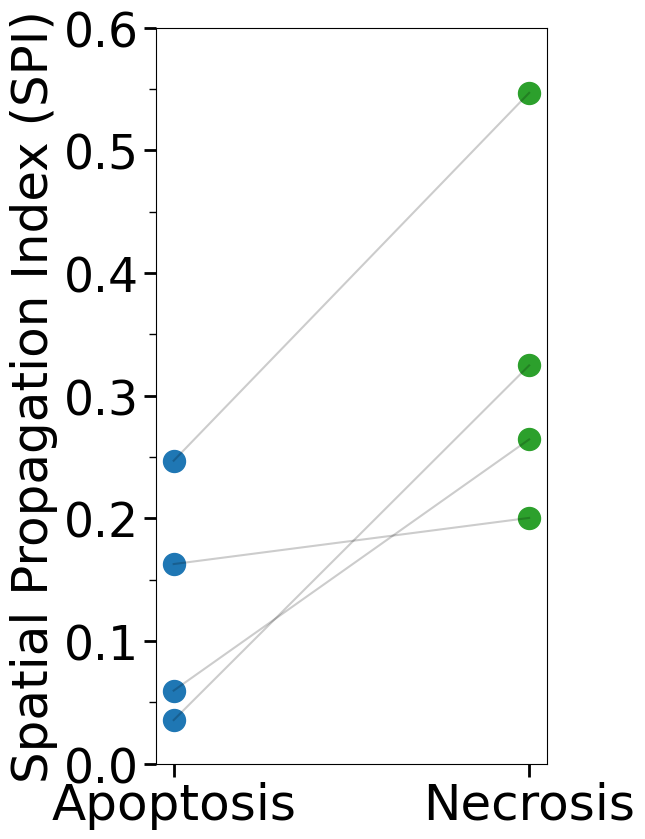

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
custom_palette =  {"ApoptosisInColonies": "#1f77b4", "NecrosisInColonies": "#2ca02c"}#{"ApoptosisInColonies": "#bf7745", "NecrosisInColonies": "#f5e18a"}
{"ApoptosisInColonies": "#1f77b4", "NecrosisInColonies": "#2ca02c"}
{"apoptosis": "#bf7745", "necrosis": "#f5e18a"}

# Replace treatment with origin and group values
# Filter the data for distance of 100 and sliding time window of 10
filtered_subset = filtered_df[
    (filtered_df['neighbors_dist_threshold'] == 100) &
    (filtered_df['sliding_time_window_size'] == 10)
]
origins = filtered_subset['Origin'].unique()
group_a_values = []
group_b_values = []
treatment_labels = []
markers = ['o', 'o', 'o', 'o'] #markers = ['o', 'x', 's', '+']
origin_marker_dict = {origin: markers[i % len(markers)] for i, origin in enumerate(origins)}
# X positions: 0 for Group A, 1 for Group B
x_a = np.zeros(len(origins))
x_b = np.ones(len(origins))
# Assign markers based on origin
origin_markers = [origin_marker_dict[origin] for origin in origins]
for origin in origins:
    subset = filtered_subset[filtered_subset['Origin'] == origin]
    group_a = subset[subset['Treatment'] == 'ApoptosisInColonies']['SPI'].mean()
    group_b = subset[subset['Treatment'] == 'NecrosisInColonies']['SPI'].mean()
    if not np.isnan(group_a) and not np.isnan(group_b):
        group_a_values.append(group_a)
        group_b_values.append(group_b)
        treatment_labels.append(origin)  # Use treatment labels instead of origin

# Plot
plt.figure(figsize=(6.5, 8.5))

for i in range(len(treatment_labels)):
    # Line connecting values
    plt.plot([x_a[i], x_b[i]], [group_a_values[i], group_b_values[i]], 'k-', alpha=0.2)
    # Group A point
    plt.scatter(x_a[i], group_a_values[i], color=custom_palette['ApoptosisInColonies'], marker=origin_markers[i], label='Apoptosis' if i == 0 else "", s=250)
    # Group B point
    plt.scatter(x_b[i], group_b_values[i], color=custom_palette['NecrosisInColonies'], marker=origin_markers[i], label='Necrosis' if i == 0 else "", s=250)

custom_legend = [Line2D([0], [0], marker=marker, color='k', markerfacecolor='k', markersize=10, label=origin)
                 for origin, marker in origin_marker_dict.items()]
# Formatting
plt.xticks([0, 1], ['Apoptosis', 'Necrosis'], fontsize=36)
plt.gca().tick_params(axis='x', which='major', length=9, width=2, labelsize=36)
plt.gca().tick_params(axis='y', which='major', length=9, width=2, labelsize=34)
plt.gca().tick_params(axis='y', which='minor', length=5, width=1)
plt.gca().set_yticks(np.arange(0.0, 0.7, 0.05), minor=True)
# plt.yticks(np.arange(0.0, 0.7, 0.05), fontsize=22)
# plt.yticks(fontsize = 22)
plt.ylabel("Spatial Propagation Index (SPI)", fontsize = 36)
# plt.title("SPI Values Across Treatments")
plt.ylim(0.0, 0.6)
plt.legend(handles=custom_legend, title="Origins", loc='lower right').remove()
plt.grid(False)
plt.tight_layout()
plt.gca().set_facecolor('none')
if savefig:
    plt.savefig("/home/esraan/CellDeathSpreading/results/newSPIAcrossOrigins_paperf_dc_r.svg", format="svg", facecolor='none')
plt.show()


## figure 2G

In [2]:
exps_dir_name = '/sise/assafzar-group/assafzar/Esraa/SalJyoPaperFiles/mixed_pure_death_minutes_microns/'
meta_data_file_full_path= "/sise/assafzar-group/assafzar/Esraa/SalJyoPaperFiles/all_csv_files_minutes_microns_with_sytox.csv"
meta_data_extract_exp_names= pd.read_csv(meta_data_file_full_path)
exp_names = meta_data_extract_exp_names.iloc[:,1]

In [3]:
exp_names_u = exp_names[exp_names.str.contains('mixed')].reset_index(drop=True)
exp_names_u =[exp_names_u[3], exp_names_u[0],exp_names_u[2],exp_names_u[1]]
exp_names_u

['7-20-23_10arednuclei_ROI#13_or14_both_colonies_annotation_mixed.csv',
 'field13_crop-001_ROI#1_annotation_mixed.csv',
 '7-20-23_10arednuclei_ROI#10_annotation_mixed.csv',
 'Field14-002_ROI#1_annotation_mixed.csv']

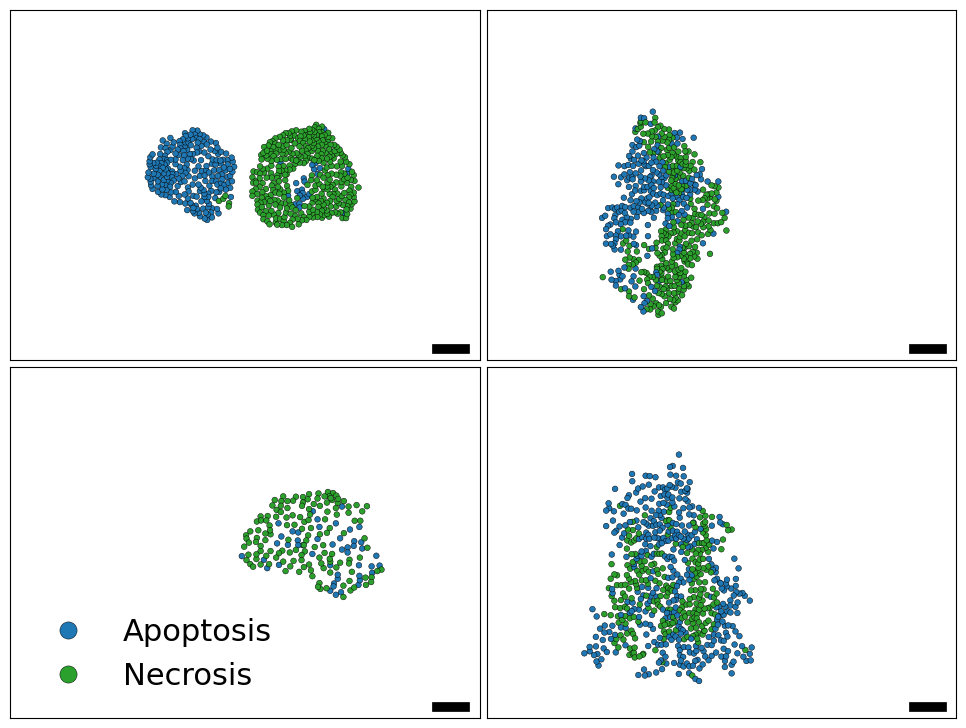

In [ ]:


custom_palette = {"Apoptosis": "#1f77b4", "Necrosis": "#2ca02c", "Other": "lightgray"}
# custom_palette = {"apoptosis": "#bf7745", "necrosis": "#fcf1c5"}
# custom_palette_2 = {"apoptosis": "#6d160d", "necrosis": "#d2ad78"}

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12.3, 9.2), sharex=False, sharey=False)

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Initialize a counter for subplot index
subplot_idx = 0

# Iterate over each file in exp_names
for file_name in exp_names_u:
    if 'mixed' not in file_name:
        continue  # Skip files that do not contain 'mixed'

    # Get metadata for the current file
    metadata = meta_data_extract_exp_names[meta_data_extract_exp_names["File Name"] == file_name]
    if metadata.empty:
        print(f"Metadata not found for {file_name}. Skipping...")
        continue

    size_x = int(metadata["SizeX"].values[0])
    size_y = int(metadata["SizeY"].values[0])
    physical_size_x = float(metadata["PhysicalSizeX"].values[0])
    physical_size_y = float(metadata["PhysicalSizeY"].values[0])

    # Calculate x and y limits
    x_limit = (0, size_x * physical_size_x)
    y_limit = (0, size_y * physical_size_y)

    # Construct the full file path
    file_path = os.path.join(exps_dir_name, file_name)
    if not os.path.exists(file_path):
        print(f"File {file_path} not found. Skipping...")
        continue

    # Read the CSV file
    data = pd.read_csv(file_path)
    data = data[data["Mode"].str.lower().isin(["apoptosis", "necrosis", "apoptotic", "necrotic"])]
    legend_labels = {"apoptotic": "apoptosis", "necrotic": "necrosis"}
    data["Mode"] = data["Mode"].replace(legend_labels)
    data["Mode"] = data["Mode"].str.capitalize()
    if data.empty:
        print(f"No valid data in {file_name}. Skipping...")
        continue

    # Plot combined modes with their respective shades
    sns.scatterplot(
        ax=axs[subplot_idx],
        data=data,
        x="cell_x",
        y="cell_y",
        hue="Mode",
        palette=custom_palette,
        edgecolor="black",
        s=17,
    )
    axs[subplot_idx].set_xlim(x_limit)
    axs[subplot_idx].set_ylim(y_limit)

    # Set the aspect ratio to preserve the original ratio
    aspect_ratio = (x_limit[1] - x_limit[0]) / (y_limit[1] - y_limit[0])
    axs[subplot_idx].set_box_aspect(1 / aspect_ratio)

    # axs[subplot_idx].set_aspect(aspect_ratio)

    # Remove x and y ticks and labels
    axs[subplot_idx].tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
    axs[subplot_idx].set_xlabel("", fontsize=24)
    axs[subplot_idx].set_ylabel("", fontsize=24)

    # Add a scale bar at the lower-right corner
    scale_bar_length = 100  # Length of the scale bar
    scale_bar_x = x_limit[1] - scale_bar_length - 50  # Position of the scale bar (x-coordinate)
    scale_bar_y = y_limit[0] + 40  # Position of the scale bar (y-coordinate)
    axs[subplot_idx].add_line(Line2D([scale_bar_x, scale_bar_x + scale_bar_length],
                                     [scale_bar_y, scale_bar_y],
                                     color="black", linewidth=7))
    axs[subplot_idx].set_facecolor('none')

    # Remove legend for all but the last subplot
    if subplot_idx == 2:
        axs[subplot_idx].legend(loc="lower left", fontsize=22, scatterpoints=5, markerscale=3, frameon=False)
    else:
        axs[subplot_idx].get_legend().remove()

    # Increment subplot index
    subplot_idx += 1

    # Stop if all subplots are filled
    if subplot_idx >= len(axs):
        break

# Adjust layout and show the plots
# plt.tight_layout()
plt.subplots_adjust(wspace=0.0001, hspace=0.02)  # Minimize space between subplots
if savefig:
    plt.savefig(f"/home/esraan/CellDeathSpreading/results/combined_plots_with_scalebar_rearranged_n.svg", format="svg", facecolor='none')
plt.show()